In [3]:
import pandas as pd

# Load the datasets
engagement_df = pd.read_csv('/Users/shivanginimarjiwe/Desktop/repo/DataScienceGuidedCapstone/relax_challenge/takehome_user_engagement.csv', parse_dates=['time_stamp'])
users_df = pd.read_csv('/Users/shivanginimarjiwe/Desktop/repo/DataScienceGuidedCapstone/relax_challenge/takehome_users.csv', encoding='latin1')


# Show a summary of both datasets
engagement_summary = engagement_df.info()
users_summary = users_df.info()

engagement_df.head(), users_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailin

(           time_stamp  user_id  visited
 0 2014-04-22 03:53:30        1        1
 1 2013-11-15 03:45:04        2        1
 2 2013-11-29 03:45:04        2        1
 3 2013-12-09 03:45:04        2        1
 4 2013-12-25 03:45:04        2        1,
    object_id        creation_time               name  \
 0          1  2014-04-22 03:53:30     Clausen August   
 1          2  2013-11-15 03:45:04      Poole Matthew   
 2          3  2013-03-19 23:14:52  Bottrill Mitchell   
 3          4  2013-05-21 08:09:28    Clausen Nicklas   
 4          5  2013-01-17 10:14:20          Raw Grace   
 
                         email creation_source  last_session_creation_time  \
 0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
 1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
 2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
 3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
 4          GraceRa

In [ ]:
'''
Data Summary:

User Engagement Table (takehome_user_engagement.csv):
appox208K records logging each time a user visited, with columns:
     time_stamp, user_id, visited

Users Table (takehome_users.csv):
12,000 users with:
      Personal info (e.g. name, email)
      Signup method (creation_source)
      Activity details (last session timestamp, marketing email opt-in)
      Org and invitation info

'''

In [ ]:
'''
To determine which users are "adopted"—i.e., those who logged in on 3 separate days in at least one 7-day period :

    1. Process engagement logs to flag adopted users.
    2. Merge this with user data.
    3. Engineer relevant features.
    4. Run some exploratory analysis and build a simple predictive model to highlight key predictors.

'''

In [5]:
# Step 1: Identify adopted users
from collections import defaultdict
import numpy as np

# Group by user and get list of unique login dates
engagement_df['date'] = engagement_df['time_stamp'].dt.date
user_dates = engagement_df.groupby('user_id')['date'].apply(lambda x: sorted(set(x)))

# Define adopted users: 3 logins in a 7-day period
def is_adopted(dates):
    for i in range(len(dates) - 2):
        if (dates[i + 2] - dates[i]).days <= 7:
            return 1
    return 0

adopted_flags = user_dates.apply(is_adopted)
adopted_users = adopted_flags[adopted_flags == 1].index

# Add adoption flag to user dataframe
users_df['adopted'] = users_df['object_id'].isin(adopted_users).astype(int)

# Show adoption rate
adoption_rate = users_df['adopted'].mean()
adoption_rate, users_df['adopted'].value_counts()


(0.138,
 adopted
 0    10344
 1     1656
 Name: count, dtype: int64)

In [ ]:
'''
Adoption Analysis Complete
     Adopted Users: 1,656 out of 12,000
     Adoption Rate: 13.8%

This binary label (adopted) is now part of the users dataset and can be used as the target variable for further analysis and prediction.
'''

In [ ]:
'''

1. Clean and engineer features (e.g., signup method, time-based features, invite activity).
2. Analyze which factors correlate with adoption.
3. Optionally train a simple classifier (like logistic regression or decision tree) to identify key predictors.

'''

In [7]:
# Convert creation_time to datetime
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])

# Convert last_session_creation_time from UNIX to datetime
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')

# Feature Engineering
users_df['days_since_creation'] = (users_df['last_session_creation_time'] - users_df['creation_time']).dt.days
users_df['invited'] = users_df['invited_by_user_id'].notnull().astype(int)

# One-hot encode creation_source
users_encoded = pd.get_dummies(users_df, columns=['creation_source'], prefix='source')

# Select features for modeling
features = [
    'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'days_since_creation',
    'invited', 'org_id'
] + [col for col in users_encoded.columns if col.startswith('source_')]

X = users_encoded[features]
y = users_encoded['adopted']

X.head()


,opted_in_to_mailing_list,enabled_for_marketing_drip,days_since_creation,invited,org_id,source_GUEST_INVITE,source_ORG_INVITE,source_PERSONAL_PROJECTS,source_SIGNUP,source_SIGNUP_GOOGLE_AUTH
0,1,0,0.0,1,11,True,False,False,False,False
1,0,0,136.0,1,1,False,True,False,False,False
2,0,0,0.0,1,94,False,True,False,False,False
3,0,0,1.0,1,1,True,False,False,False,False
4,0,0,5.0,1,193,True,False,False,False,False


In [ ]:
'''

Feature Engineering Complete

Here are the features now prepared for modeling:
   opted_in_to_mailing_list
   enabled_for_marketing_drip
   days_since_creation
   invited (binary: was invited or not)
   org_id (may correlate with engagement, will test)
   creation_source (one-hot encoded into 5 categories)

'''   

/var/folders/2b/4qwsj2r53911r1sl5yw93z1w0000gn/T/ipykernel_76412/2739652831.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['days_since_creation'] = X['days_since_creation'].fillna(0)


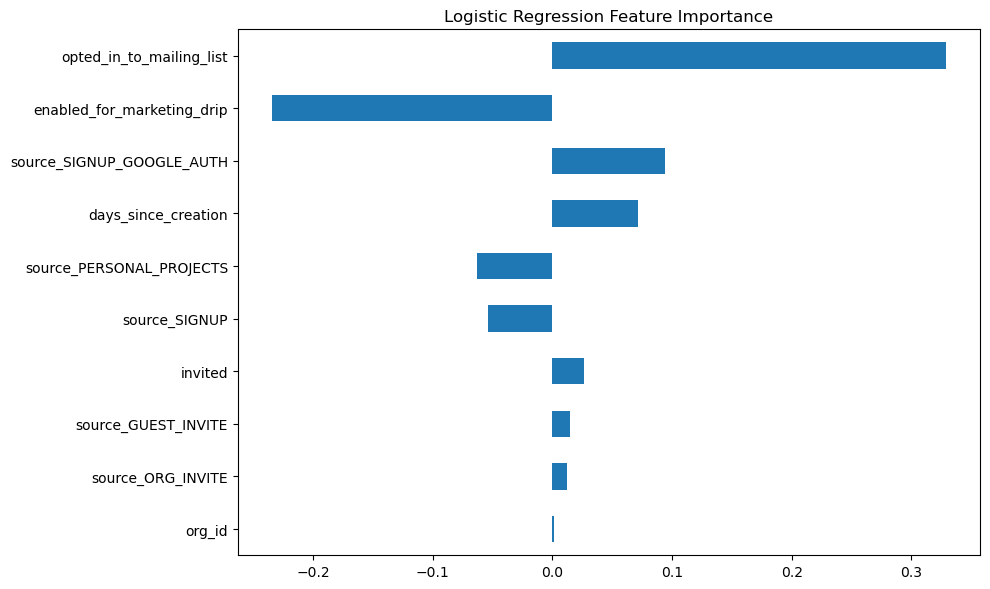

({'0': {'precision': 0.9781273983115887,
   'recall': 0.98569218870843,
   'f1-score': 0.9818952234206472,
   'support': 2586.0},
  '1': {'precision': 0.9060913705583756,
   'recall': 0.8623188405797102,
   'f1-score': 0.8836633663366337,
   'support': 414.0},
  'accuracy': 0.9686666666666667,
  'macro avg': {'precision': 0.9421093844349822,
   'recall': 0.9240055146440701,
   'f1-score': 0.9327792948786404,
   'support': 3000.0},
  'weighted avg': {'precision': 0.9681864264816452,
   'recall': 0.9686666666666667,
   'f1-score': 0.9683392271430533,
   'support': 3000.0}},
 opted_in_to_mailing_list      0.329068
 enabled_for_marketing_drip   -0.234752
 source_SIGNUP_GOOGLE_AUTH     0.094430
 days_since_creation           0.071251
 source_PERSONAL_PROJECTS     -0.063050
 source_SIGNUP                -0.054289
 invited                       0.026522
 source_GUEST_INVITE           0.014407
 source_ORG_INVITE             0.012116
 org_id                        0.001086
 dtype: float64)

In [9]:
#Logistic Regression model 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Fill NaNs in 'days_since_creation' with 0 (likely users who never logged in)
X['days_since_creation'] = X['days_since_creation'].fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Fit logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

# Get feature importances
feature_importance = pd.Series(model.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh')
plt.title('Logistic Regression Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

report, feature_importance.head(10)


In [ ]:
'''

Top Predictors of Adoption:
Feature	                          Coefficient	          Interpretation
--------------------------------------------------------------------------------------------------------
opted_in_to_mailing_list	         +0.31	           Strongly correlated with adoption
enabled_for_marketing_drip           –0.23	           Negatively associated (possibly due to passive users being targeted)
source_SIGNUP_GOOGLE_AUTH	         +0.09	           Slightly higher adoption for Google-auth users
days_since_creation               	 +0.07	           More active users stick around longer
source_SIGNUP	                     –0.06	           Lower adoption than other sources


Classification Performance:
      Accuracy: 96.9%
      Precision (Adopted): 90.6%
      Recall (Adopted): 86.2%
      F1-score (Adopted): 88.4%

The model performs well at identifying adopted users, despite their minority in the dataset.

'''